<a href="https://colab.research.google.com/github/RafalDoroz/ai/blob/main/shap-basic-guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import wszystkich wymaganych bibliotek

In [20]:
# W Google Colab trzeba najpierw zainstalować bibliotekę SHAP (odkomentuj poniższą linię):
! pip install shap

In [21]:
# Import biblioteki SHAP (do obliczeń wartości Shapleya i wizualizacji)
import shap

# Implementacja XGBoost do modelu regresji/drzew
import xgboost

# Funkcja z Scikit-learn do podziału zbioru na treningowy i testowy
from sklearn.model_selection import train_test_split

# Funkcja z Scikit-learn do obliczania średniego błędu kwadratowego (MSE)
from sklearn.metrics import mean_squared_error


# 2.  Załaduj przykładowy zbiór danych

Będziemy korzystać z California housing dataset (https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

In [22]:
# X to cechy, a y to wartości docelowe
X, y = shap.datasets.california()

Podzielmy dane na zbiór treningowy (80%) i testowy (20%):

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Wytrenuj model XGBoost

Inicjalizacja modelu XGBoost (regresja):



In [25]:
model = xgboost.XGBRegressor()

Uczenie modelu na danych treningowych:

In [6]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Predykcja na zbiorze testowym:

In [7]:
predictions = model.predict(X_test)

Obliczenie błędu (MSE):

In [8]:
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 0.207833


# 4. Wyjaśnianie modelu XGBoost za pomocą biblioteki SHAP

## 4.1. Szacowanie wartości Shapleya

Tworzymy explainer, który policzy wartości Shapleya:

Używamy zbiór treningowy X_train do obliczeń

In [9]:
explainer = shap.Explainer(model=model, masker=X_train)

Sprawdzamy klasę explainer’a (powinno pokazać TreeExplainer):

In [23]:
explainer.__class__

shap.explainers._tree.TreeExplainer

Liczymy wartości Shapleya dla zbioru testowego:

In [11]:
shap_values = explainer(X_test)

100%|===================| 4122/4128 [00:25<00:00]       

## 4.2. Local explanations

Wyjaśnienia lokalne (dla pojedynczych prognoz)

### Waterfall Plot

Waterfall Plot – pokazuje, jak cecha po cesze „dodaje” lub „odejmuje” od wartości bazowej (base_value):

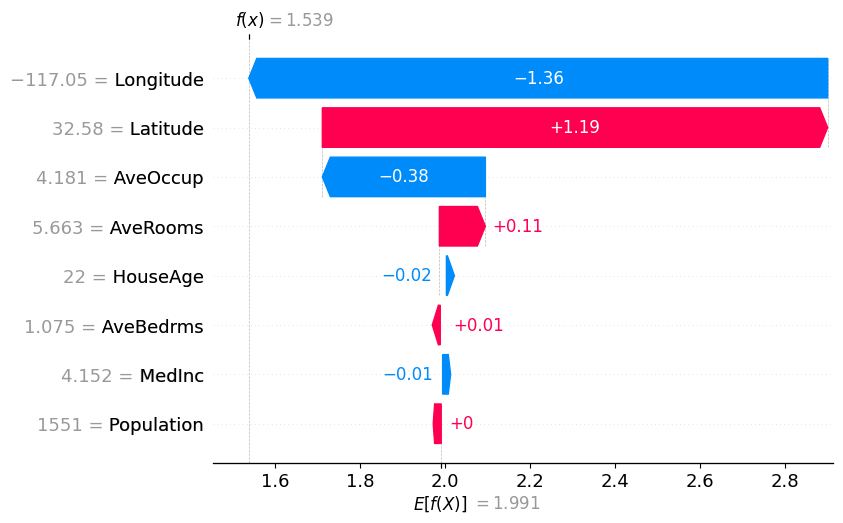

In [12]:
shap.plots.waterfall(shap_values[0])

**Co widać na wykresie?**
f(x) = 1.539 – to wynik modelu (dla konkretnej obserwacji).

E[f(X)] = 1.991 – to wartość bazowa (baseline), czyli średnia prognoza modelu dla wszystkich danych treningowych.

Czerwone i niebieskie „paski” – to wkład poszczególnych cech (SHAP values):

🔴 Czerwony pasek (wartość dodatnia) – cecha podnosi przewidywaną wartość (popycha wynik modelu w górę).

🔵 Niebieski pasek (wartość ujemna) – cecha obniża przewidywaną wartość (popycha wynik modelu w dół).

Po lewej widzimy konkretne wartości cech (np. Longitude = -117.05, Latitude = 32.58).

Każda cecha ma obok siebie liczbę, np. -1.36, +1.19, -0.38 – to wartość SHAP (ile ta cecha zmienia wynik).

---


**Jak to czytać?**

1️. Zaczynamy od wartości bazowej (E[f(X)] = 1.991)
➡ Model „na starcie” przewiduje średnią wartość z danych treningowych.

2️. Dodajemy wkład każdej cechy

Longitude = -117.05 → –1.36 – silnie obniża wynik.

Latitude = 32.58 → +1.19 – prawie równoważy wpływ Longitude, mocno podnosi wynik.

AveOccup = 4.181 → –0.38 – też trochę obniża wynik.

Pozostałe cechy mają niewielki wpływ (np. AveRooms = +0.11, HouseAge = -0.02).

3️. Końcowy wynik modelu
➡ Wszystkie SHAP values są sumowane:
Wartość bazowa 1.991 + suma wpływów (-1.36 + 1.19 - 0.38 + 0.11 …) = f(x) = 1.539.

---

Co nam to mówi o tym konkretnym przypadku?
Najważniejszy wpływ miały:

- Longitude – obniżył prognozę aż o 1.36 jednostki.

- Latitude – podniósł prognozę o 1.19 jednostki.

Cecha AveOccup (średnia liczba mieszkańców w domu) – trochę obniżyła prognozę.

Pozostałe cechy (AveRooms, HouseAge, AveBedrms, MedInc, Population) miały marginalny wpływ.

**Jak interpretować takie wykresy ogólnie?**
Cel:
Wyjaśnić dlaczego model przewidział taką wartość dla konkretnej obserwacji.

**Interpretacja kolorów:**

🔴 Czerwone paski – cechy ukierunkowują wynik modelu w stronę wyższej prognozy.

🔵 Niebieskie paski – cechy ukierunkowują wynik modelu w stronę niższej prognozy.

### Force Plot

Interaktywna wizualizacja wartości Shapleya:

Wizualizacja wartości Shapleya dla prognozy pierwszego przypadku w  zestawie danych testowych przy użyciu wykresu siłowego

In [24]:
shap.initjs()
shap.plots.force(shap_values[0])

**Jak czytać taki wykres?**

1. Linia bazowa

base value = 1.991 – to średnia prognoza modelu dla wszystkich danych treningowych.
➡ To punkt startowy, od którego model „zaczyna” obliczanie przewidywania.

2. Wynik modelu (f(x))
f(x) = 1.54 – to ostateczna predykcja modelu dla tej konkretnej obserwacji.

3. Strzałki i kolory

🔴 Czerwone strzałki → cechy, które zwiększają przewidywaną wartość.

🔵 Niebieskie strzałki → cechy, które obniżają przewidywaną wartość.

Długość strzałki = siła wpływu cechy (wartość SHAP).

---

📊 Interpretacja wykresu

AveRooms = 5.663 (czerwony) – ta cecha podniosła wynik modelu (przesunęła go w stronę wyższych wartości).

Latitude = 32.58 (czerwony) – również zwiększyła przewidywaną wartość.

Longitude = -117 (niebieski) – obniżył wynik modelu (duży wpływ ujemny).

AveOccup = 4.181 (niebieski) – także „pociągnął” wynik w dół, ale słabiej.

---

**Co z tego wynika?**

➡ Model zaczyna od wartości bazowej (1.991).
➡ Dodaje wpływ czerwonych cech (np. AveRooms i Latitude).
➡ Odejmowane są wpływy niebieskich cech (Longitude i AveOccup).
➡ Sumując to wszystko otrzymujemy końcową prognozę (1.54).

---

Jak używać force plot w praktyce?

-Pokazuje dlaczego model wydał taką decyzję dla jednego konkretnego przypadku.

-Widać, które cechy mają największy wpływ, a które prawie nie zmieniają wyniku.

-Pomaga w audytach modeli (np. czy model nie kieruje się cechami, które nie powinny wpływać na decyzję – np. płeć, wiek).

## 4.3. Global explanations

Wyjaśnienia globalne (dla całego modelu)

### Bar Plot

Pokazuje średni wpływ każdej cechy:

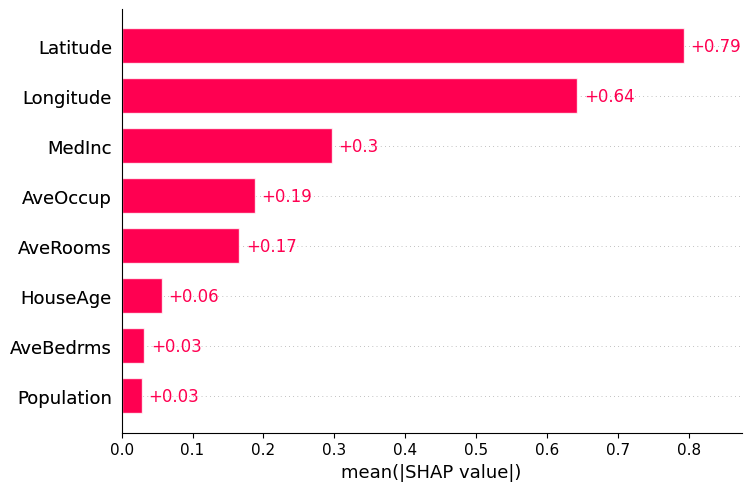

In [15]:
shap.plots.bar(shap_values)

Co oznacza ten wykres?

1. Każdy pasek = jedna cecha

Latitude, Longitude, MedInc, AveOccup... – to cechy modelu.

Kolejność jest ustalona od najważniejszej (góra) do najmniej ważnej (dół).

2. Długość paska = średnia bezwzględna wartość SHAP (mean(|SHAP value|))

Mierzy, jak bardzo dana cecha wpływała na predykcje modelu we wszystkich próbkach:

długi pasek = cecha bardzo ważna,

krótki pasek = cecha prawie nie wpływa.


3. Liczby przy paskach

Np. +0.79 przy Latitude oznacza, że średni wkład (bez względu na kierunek) tej cechy w decyzję modelu to 0.79 jednostki wyniku modelu.


---



Interpretacja Twojego wykresu

Latitude (szerokość geograficzna) – najważniejsza cecha (średni wkład ~0.79).

Longitude (długość geograficzna) – druga najważniejsza cecha (~0.64).

MedInc (średni dochód) – trzecia pod względem ważności (~0.30).

Pozostałe cechy (AveOccup, AveRooms, HouseAge, AveBedrms, Population) mają coraz mniejszy wpływ.


---


Jak używać takich wykresów?

Do czego służy?

Pokazuje globalną interpretację modelu – które cechy najczęściej wpływają na wyniki.

Pozwala na priorytetyzację cech – np. w analizie biznesowej możesz powiedzieć: „model głównie patrzy na szerokość i długość geograficzną”.

Na co uważać?

Wartość jest bezwzględna – czyli nieważne, czy cecha podnosiła czy obniżała wynik – liczy się sam wpływ.

To uśrednienie po wszystkich próbkach – nie pokazuje różnic lokalnych (np. w jednym przypadku Latitude mogła działać pozytywnie, w innym negatywnie).



Możemy ograniczyć liczbę wyświetlanych cech:

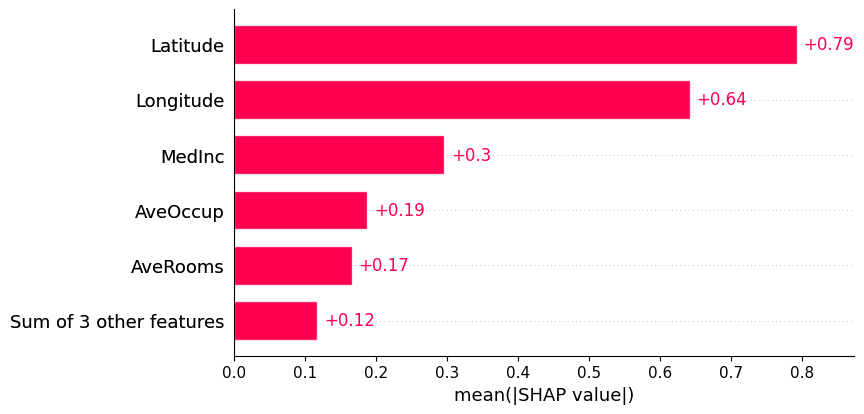

In [16]:
shap.plots.bar(shap_values, max_display=6)

### Beeswarm Plot

Każdy punkt to jedna wartość SHAP dla jednej obserwacji:

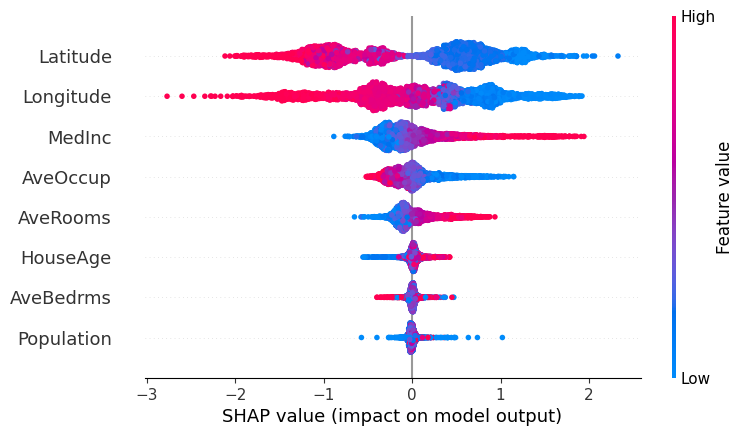

In [17]:
shap.plots.beeswarm(shap_values)

SHAP beeswarm plot, czyli wykres rojowy SHAP.


To jeden z najważniejszych wykresów w SHAP, bo daje globalny obraz modelu i jednocześnie pokazuje rozkład wartości cech.


---


Jak czytać ten wykres?

1. Każdy rząd to jedna cecha
Latitude, Longitude, MedInc, AveOccup… – cechy modelu.

Rzędy są uporządkowane od najważniejszej do najmniej ważnej (tak jak w bar plot).

2. Każda kropka = jedna obserwacja
Kropka pokazuje wartość SHAP dla danej cechy w jednej próbce:

Położenie w poziomie (oś X) = wpływ cechy na wynik modelu:

wartość SHAP > 0 → cecha pcha przewidywanie w górę,

wartość SHAP < 0 → cecha pcha przewidywanie w dół.

Kolor kropki = wartość cechy:

🔴 czerwony = wysoka wartość cechy,

🔵 niebieski = niska wartość cechy.

3. Gęstość kropek = „kształt chmury”

Im więcej kropek w danym miejscu, tym bardziej model „skupia” swoje decyzje wokół tych wartości SHAP.

Interpretacja Twojego wykresu

Latitude (szerokość geograficzna):

Czerwone kropki (wysoka wartość) są po lewej – wysokie wartości latitude obniżają wynik modelu.

Niebieskie kropki (niskie wartości) są po prawej – niskie latitude podnoszą wynik modelu.

Longitude (długość geograficzna):

Analogicznie – model wyraźnie reaguje na długość geograficzną.

MedInc (średni dochód):

Czerwone punkty przesuwają się w prawo → wysoki dochód zwiększa przewidywanie.

Cechy niżej (HouseAge, AveBedrms, Population):

Wpływ jest minimalny (chmury wąskie, skupione przy 0).


---


📖 Co nam daje beeswarm plot?
✅ Globalne spojrzenie – widzimy:

które cechy są najważniejsze (pozycja na liście),

jaki jest zakres ich wpływu (rozciągnięcie kropek na osi X),

kierunek wpływu (czy wysokie wartości cechy „popychają” wynik w górę czy w dół).

✅ Kolor dodaje kontekst – od razu widać, czy „wysokie wartości” cechy zwiększają czy zmniejszają przewidywanie modelu.

### Force Plot

Wizualizacja dla pierwszych 100 predykcji:

In [18]:
shap.initjs()
shap.plots.force(shap_values[0:100])